In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
import math
from db_utils import DbConnect

In [2]:
db = DbConnect(
    "../connection.config.yml", "../role-basic.config.yml"
).create_db_connection("postgres-storage/inflation", "inflation")

In [4]:
countries = db.query("SELECT * FROM inflation.country_list;")
countries

,id,country_name,country_code,indicator_id
0,1,Aruba,ABW,1
1,2,Africa Eastern and Southern,AFE,1
2,3,Afghanistan,AFG,1
3,4,Africa Western and Central,AFW,1
4,5,Angola,AGO,1
...,...,...,...,...
261,262,Kosovo,XKX,1
262,263,"Yemen, Rep.",YEM,1
263,264,South Africa,ZAF,1
264,265,Zambia,ZMB,1


In [4]:
country_codes = ["USA", "TUR"]
country_strings = ", ".join([f"'{country_code}'" for country_code in country_codes])

In [5]:
inflation_values = db.query(
    f"SELECT * FROM inflation.view_multi_country(ARRAY{country_codes})"
)
inflation_values

,country_id,data_id,country_name,country_code,observation_year,inflation_value,indicator_name,indicator_code
0,245,15129,Turkiye,TUR,1960,5.664740,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
1,245,15130,Turkiye,TUR,1961,3.172857,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
2,245,15131,Turkiye,TUR,1962,3.888320,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
3,245,15132,Turkiye,TUR,1963,6.362707,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
4,245,15133,Turkiye,TUR,1964,1.119638,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
...,...,...,...,...,...,...,...,...
119,252,15620,United States,USA,2017,2.130110,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
120,252,15621,United States,USA,2018,2.442583,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
121,252,15622,United States,USA,2019,1.812210,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
122,252,15623,United States,USA,2020,1.233584,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG


In [7]:
decade_regr_raw = db.query(
    f"SELECT * FROM inflation.decades_regression WHERE country_code in ({country_strings})"
)


def split_by_country_codes(raw_df, country_codes):
    processed = {}
    for country_code in country_codes:
        df = decade_regr_raw[decade_regr_raw["country_code"] == country_code]
        processed[country_code] = {
            "country_name": df["country_name"].values[0],
            "country_code": country_code,
            "df": df,
        }
    return processed


decade_regr = split_by_country_codes(decade_regr_raw, country_codes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


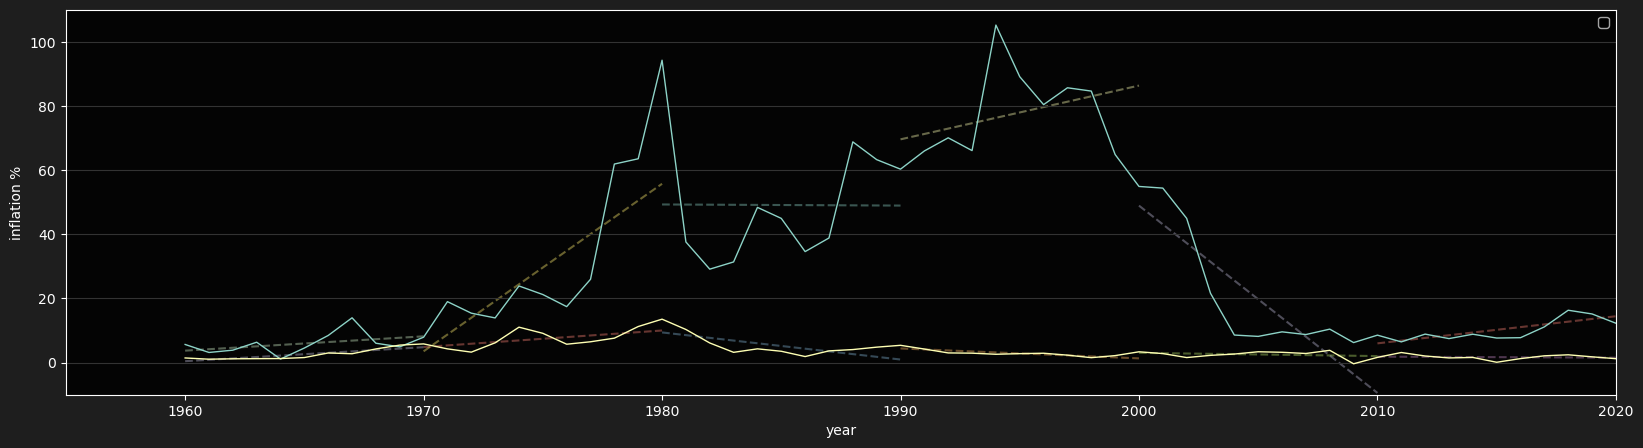

In [8]:
plt.style.use("dark_background")

fig, ax = plt.subplots()
fig.set_size_inches((20, 5))
fig.set_facecolor("#1e1e1e")

ax.set_facecolor("#040404")
ax.grid(axis="y", which="major", color="#333333")
ax.set_ylabel("inflation %")
ax.set_xlabel("year")
ax.legend()
ax.set_ylim(-10, 110)
ax.set_xlim(1955, 2020)


def add_country_inflation_data():
    for country_code in inflation_values["country_code"].unique():
        country_df = inflation_values[inflation_values["country_code"] == country_code]
        country_name = country_df["country_name"].values[0]
        ax.plot(
            "observation_year",
            "inflation_value",
            data=country_df,
            linewidth=1.0,
            label=country_name,
        )


def add_decade_trends():
    for country_code in country_codes:
        for decade in range(1960, 2020, 10):
            df = decade_regr[country_code]["df"]
            intercept = df["intercept"].loc[df["decade"] == decade].values[0]
            slope = df["slope"].loc[df["decade"] == decade].values[0]
            x_points = [decade, decade + 10]
            y_points = [intercept + slope * x_point for x_point in x_points]
            ax.plot(x_points, y_points, linestyle="--", zorder=0, alpha=0.4)


add_country_inflation_data()
add_decade_trends()

In [9]:
inflation_stats = db.query(
    f"SELECT * FROM inflation.decade_stats WHERE country_code IN ({country_strings});"
)
inflation_stats

,country_name,country_code,decade,count,average,max,min,median,range,stddev,variance
0,Turkiye,TUR,1960.0,10,5.82,13.97,1.12,5.29,12.86,3.48,12.13
1,Turkiye,TUR,1970.0,10,27.03,63.54,7.92,20.12,55.62,19.50,380.09
2,Turkiye,TUR,1980.0,10,49.13,94.26,29.14,41.91,65.12,20.56,422.82
3,Turkiye,TUR,1990.0,10,77.24,105.22,60.30,75.24,44.91,14.15,200.20
4,Turkiye,TUR,2000.0,10,22.77,54.92,6.25,10.02,48.66,20.37,415.13
5,Turkiye,TUR,2010.0,10,9.84,16.33,6.47,8.71,9.86,3.36,11.29
6,Turkiye,TUR,2020.0,2,15.94,19.60,12.28,15.94,7.32,5.17,26.77
7,United States,USA,1960.0,10,2.34,5.46,1.07,1.52,4.39,1.52,2.30
8,United States,USA,1970.0,10,7.09,11.25,3.27,6.34,7.98,2.68,7.17
9,United States,USA,1980.0,10,5.55,13.55,1.90,4.19,11.65,3.62,13.09


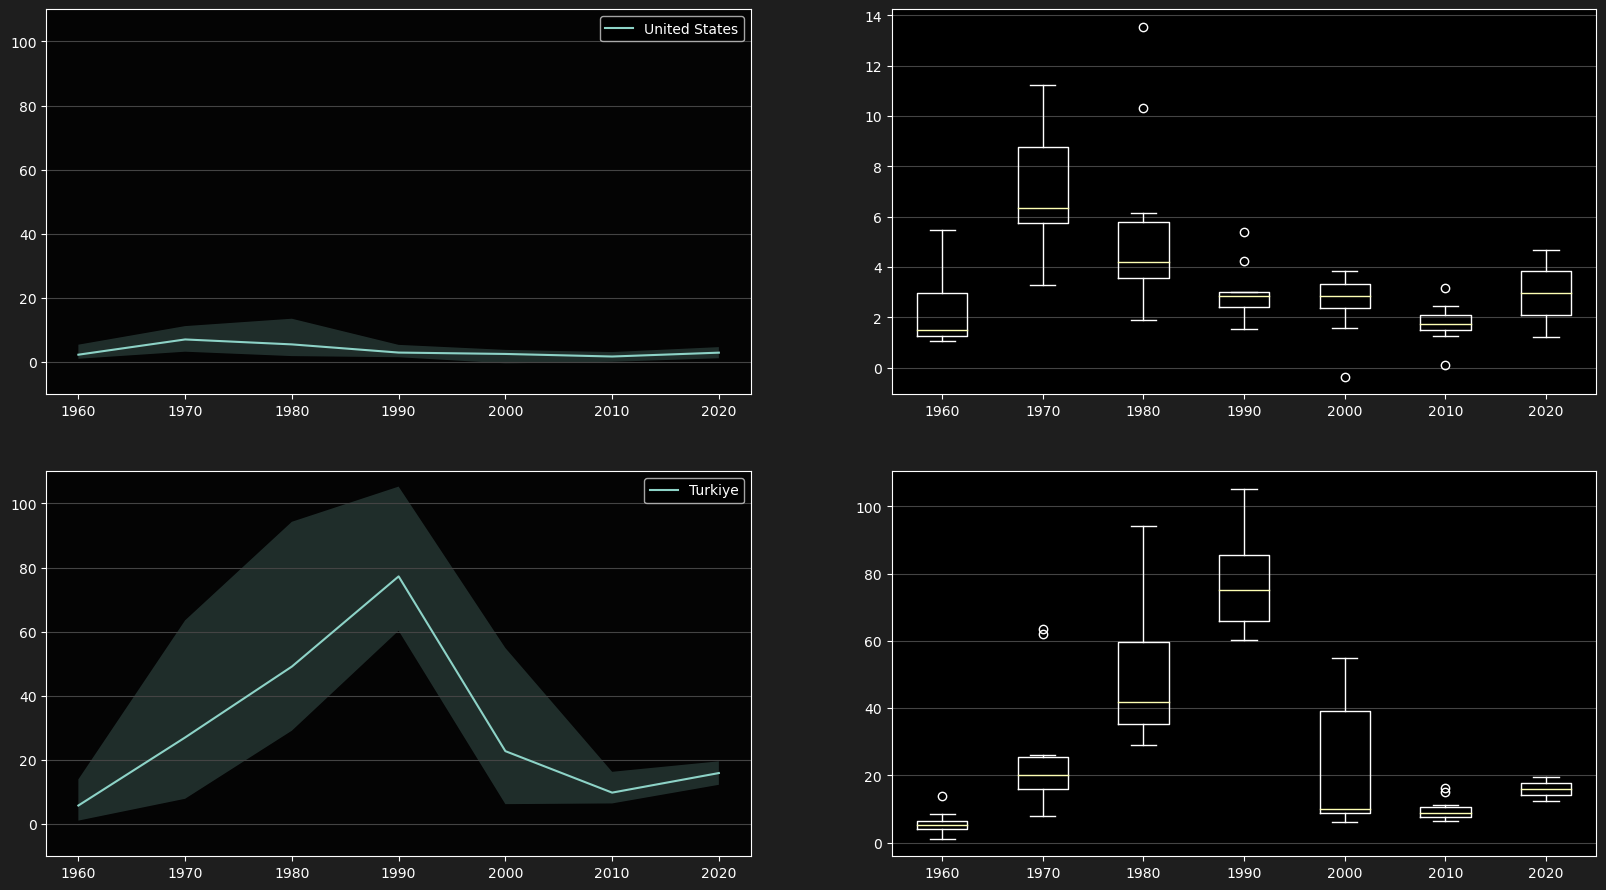

In [10]:
fig, axs = plt.subplots(2, 2)
fig.set_facecolor("#1e1e1e")
fig.set_size_inches((20, 11))


def plot_decade_inflation(ax, country_code, inflation_stats):
    country_df = inflation_stats[inflation_stats["country_code"] == country_code]
    country_name = country_df["country_name"].values[0]
    ax.fill_between(
        country_df["decade"], country_df["max"], country_df["min"], alpha=0.2
    )
    ax.plot(country_df["decade"], country_df["average"], label=country_name)
    ax.set_facecolor("#040404")
    ax.set_ylim(-10, 110)
    ax.grid(which="major", axis="y", color="#4444447F")
    legend = ax.legend()


def plot_boxes(ax, country_code, inflation_values, inflation_stats):
    country_df = inflation_values[inflation_values["country_code"] == country_code]
    decades = inflation_stats["decade"].unique()
    decade_data = []
    for decade in decades:
        decade_df = country_df[
            country_df["observation_year"].between(decade, decade + 9)
        ]
        decade_data.append(decade_df["inflation_value"])
    # ax.set_ylim(-10, 110)
    ax.boxplot(decade_data)
    ax.set_xticklabels(decades.astype(int))
    ax.grid(which="major", axis="y", color="#4444447F")


for index, country_code in enumerate(country_codes):
    plot_decade_inflation(axs[index][0], country_code, inflation_stats)
    plot_boxes(axs[index][1], country_code, inflation_values, inflation_stats)

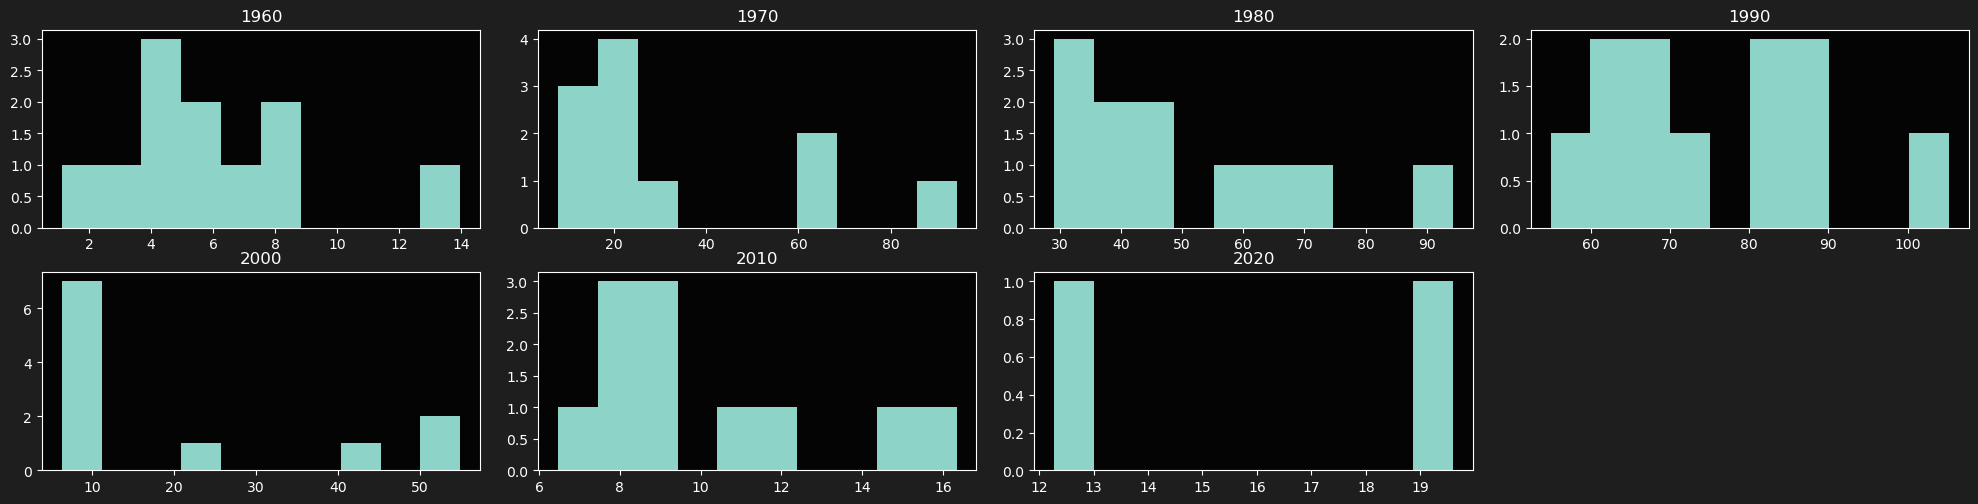

In [11]:
country_code = "TUR"

decades = inflation_stats["decade"].unique()

subplot_count_rows = 2
subplot_count_cols = int(np.ceil(len(decades) / subplot_count_rows))
fig, axs = plt.subplots(2, subplot_count_cols)
fig.set_size_inches(20, 5)
fig.set_facecolor("#1e1e1e")
fig.tight_layout()
for index in range(subplot_count_rows * subplot_count_cols):
    col = index % subplot_count_cols
    row = math.floor(index / subplot_count_cols)
    ax = axs[row][col]
    if index > len(decades) - 1:
        ax.remove()
        break
    decade = decades[index]
    decade_data = inflation_values[
        (inflation_values["country_code"] == country_code)
        & (inflation_values["observation_year"].between(decade, decade + 10))
    ]
    decade_inflation = decade_data["inflation_value"]
    ax.set_title(int(decade))
    ax.set_facecolor("#040404")
    # ax.set_xlabel("Inflation")
    # ax.set_ylabel("Count")
    histogram = ax.hist(decade_inflation)

In [12]:
all = db.query(
    """
    SELECT 
        "country_name", 
        "country_code", 
        "observation_year" AS "year", 
        "inflation_value" AS "value" 
    FROM inflation.view_all_countries_inflation_data()
"""
)
view = all[all["value"] > 200].copy().reset_index(drop=True)
view
# view.insert(0, "row", np.arange(len(view)))
# view["row"] = np.arange(len(view))
# view

,country_name,country_code,year,value
0,Angola,AGO,1992,299.50980
1,Angola,AGO,1993,1378.52760
2,Angola,AGO,1994,949.79254
3,Angola,AGO,1995,2666.45070
4,Angola,AGO,1996,4145.10600
...,...,...,...,...
85,Ukraine,UKR,1994,891.18774
86,Ukraine,UKR,1995,376.74620
87,"Venezuela, RB",VEN,2016,254.94853
88,Zimbabwe,ZWE,2019,255.30500


In [13]:
all_raw = db.query(
    """
    SELECT 
        "country_name",
        "country_code",
        "year",
        "value"
    FROM inflation.country_list c
    JOIN
        inflation.inflation_data d ON c.id = d.country_id
    ;
"""
)
all_raw

,country_name,country_code,year,value
0,Aruba,ABW,1985,4.032258
1,Aruba,ABW,1986,1.073966
2,Aruba,ABW,1987,3.643045
3,Aruba,ABW,1988,3.121869
4,Aruba,ABW,1989,3.991628
...,...,...,...,...
10484,Zimbabwe,ZWE,2017,0.893962
10485,Zimbabwe,ZWE,2018,10.618866
10486,Zimbabwe,ZWE,2019,255.305000
10487,Zimbabwe,ZWE,2020,557.201840


In [14]:
def rows(df: pd.DataFrame):
    return df["year"] > 2020


def cols(df: pd.DataFrame):
    return "year", "country_name", "year"


all_raw.loc[rows, cols]

,year,country_name,year
82,2021,Africa Eastern and Southern,2021
138,2021,Africa Western and Central,2021
197,2021,Albania,2021
245,2021,Arab World,2021
286,2021,Armenia,2021
...,...,...,...
10335,2021,Samoa,2021
10354,2021,Kosovo,2021
10440,2021,South Africa,2021
10476,2021,Zambia,2021


In [15]:
all_raw.rename(
    columns={
        "country_name": "name",
        "country_code": "code",
    },
    inplace=True,
)
row_indices = ["code", "year"]
all_raw.set_index(row_indices, inplace=True)
all_raw

name       value
code year                      
ABW  1985     Aruba    4.032258
     1986     Aruba    1.073966
     1987     Aruba    3.643045
     1988     Aruba    3.121869
     1989     Aruba    3.991628
...             ...         ...
ZWE  2017  Zimbabwe    0.893962
     2018  Zimbabwe   10.618866
     2019  Zimbabwe  255.305000
     2020  Zimbabwe  557.201840
     2021  Zimbabwe   98.546104

[10489 rows x 2 columns]

In [16]:
years = all_raw["year"].unique()
countries = all_raw["country_code"].unique()
tuples = list(zip(years, countries))
pd.MultiIndex.from_product([years, countries])

KeyError: 'year'